In [ ]:
!pip install selenium webdriver-manager
import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time
!pip install selenium webdriver-manager


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

driver_path = r"D:\Temp\ChromeDriver\chromedriver-win64\chromedriver.exe"  # Update to your path ## maybe make it dynamic later on

options = Options()
options.headless = True  # False if you want to see the browser

driver = webdriver.Chrome(
    service=Service(driver_path),
    options=options
)


In [4]:
import time
from bs4 import BeautifulSoup
import pandas as pd

url = "https://remoteok.com/remote-dev-jobs"
driver.get(url)         # Load the page in the browser
time.sleep(5)           # Wait for JavaScript to load content


In [ ]:
# Scroll down incrementally to load more jobs (let it run for a while)
SCROLL_PAUSE_TIME = 4
last_height = driver.execute_script("return document.body.scrollHeight")

for _ in range(10):  # Adjust number of scrolls depending on how many jobs you want
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height


In [6]:
soup = BeautifulSoup(driver.page_source, "html.parser")


In [7]:
job_list = []

In [8]:
import re

def extract_salary_and_clean_locations(locations):
    min_salary = None
    max_salary = None

    if not locations:
        return locations, None, None

    potential_salary = locations[-1]
    if "$" in potential_salary:
        locations = locations[:-1]  # Remove salary
        salary_clean = potential_salary.replace("💰", "").replace("$", "").strip()
        print(f"Salary raw: {potential_salary}, cleaned: {salary_clean}")

        try:
            parts = salary_clean.split("-")
            if len(parts) == 2:
                min_match = re.search(r'\d+', parts[0])
                max_match = re.search(r'\d+', parts[1])
                if min_match and max_match:
                    min_salary = int(min_match.group()) * 1000
                    max_salary = int(max_match.group()) * 1000
            elif len(parts) == 1:
                match = re.search(r'\d+', parts[0])
                if match:
                    min_salary = int(match.group()) * 1000
        except Exception as e:
            print(f"Failed to parse salary: {e}")

    return locations, min_salary, max_salary


In [ ]:
i = 0
for job in soup.find_all("tr", class_="job"):
    print(f"Processing job {i}")
    i += 1
    # Get the job title
    title_tag = job.find("h2", itemprop="title")
    title = title_tag.text.strip() if title_tag else None

    # Get the company name
    company_tag = job.find("h3", itemprop="name")
    company = company_tag.text.strip() if company_tag else None

    # Get job link (relative path, needs prefix)
    link_tag = job.find("a", class_="preventLink")
    relative_link = link_tag.get("href") if link_tag else None
    link = f"https://remoteok.com{relative_link}" if relative_link else None

    # Get all locations
    location_tags = job.find_all("div", class_="location")
    locations = [loc.text.strip() for loc in location_tags]

    
    locations, min_salary, max_salary = extract_salary_and_clean_locations(locations)

    # Optional: check if verified
    verified = job.find("span", class_="verified") is not None

    tags_td = job.find('td', class_='tags')
    tag_elements = tags_td.find_all('h3') if tags_td else []
    tags = [tag.text.strip() for tag in tag_elements]
    # print(f"company: {company}", f"Tags: {tags}")

    time = job.find('td', class_='time')
    time = time.text.strip() if time else None
    # print(company,f"Time: {time}")
    # print(time)

    # Add to list
    job_list.append({
        "title": title,
        "company": company,
        "link": link,
        "locations": ", ".join(locations),
        "min salary": min_salary,
        "max salary": max_salary,
        "verified": verified,
        "tags": tags,
        "time": time
    })
    

Processing job 0
Salary raw: 💰 $40k - $60k, cleaned: 40k - 60k
Processing job 1
Salary raw: 💰 $20k - $40k, cleaned: 20k - 40k
Processing job 2
Salary raw: 💰 $40k - $60k, cleaned: 40k - 60k
Processing job 3
Salary raw: 💰 $60k - $90k, cleaned: 60k - 90k
Processing job 4
Salary raw: 💰 $140k - $200k, cleaned: 140k - 200k
Processing job 5
Salary raw: 💰 $20k - $40k, cleaned: 20k - 40k
Processing job 6
Salary raw: 💰 $30k - $40k, cleaned: 30k - 40k
Processing job 7
Salary raw: 💰 $30k - $40k, cleaned: 30k - 40k
Processing job 8
Salary raw: 💰 $120k - $140k, cleaned: 120k - 140k
Processing job 9
Salary raw: 💰 $50k - $90k, cleaned: 50k - 90k
Processing job 10
Salary raw: 💰 $50k - $60k, cleaned: 50k - 60k
Processing job 11
Salary raw: 💰 $30k - $40k, cleaned: 30k - 40k
Processing job 12
Salary raw: 💰 $60k - $80k, cleaned: 60k - 80k
Processing job 13
Salary raw: 💰 $80k - $100k, cleaned: 80k - 100k
Processing job 14
Salary raw: 💰 $60k - $100k, cleaned: 60k - 100k
Processing job 15
Processing job 16
Sa

In [10]:
len(job_list)

548

In [12]:
job_list_pd = pd.DataFrame(job_list)
job_list_pd

,title,company,link,locations,min salary,max salary,verified,tags,time
0,Senior Python Backend Engineer,Orga AI,https://remoteok.com/remote-jobs/remote-senior...,🌏 Worldwide,40000.0,60000.0,False,"[Python, Senior, Backend, Ops, Startup, AWS]",23h
1,WordPress Plugins & Themes developer,Melapress,https://remoteok.com/remote-jobs/remote-wordpr...,"🇪🇺 Europe, 🇬🇧 United Kingdom, 🇹🇷 Turkey",20000.0,40000.0,True,"[DevOps, Wordpress, PHP, JavaScript, Full Time...",5d
2,Web Developer,MailerLite,https://remoteok.com/remote-jobs/remote-web-de...,🌏 Worldwide,40000.0,60000.0,True,[Front End],2d
3,Senior Fullstack Developer,Swipe Games,https://remoteok.com/remote-jobs/remote-senior...,🌏 Worldwide,60000.0,90000.0,True,"[Front End, Backend, Full Stack, JavaScript, N...",3d
4,Software Engineer Data Infrastructure & Acquis...,Speechify,https://remoteok.com/remote-jobs/remote-softwa...,🌏 Worldwide,140000.0,200000.0,True,[],3d
...,...,...,...,...,...,...,...,...,...
543,Senior Software Developer,Aula,https://remoteok.com/remote-jobs/102559-remote...,🌏 Worldwide,115000.0,140000.0,True,"[JavaScript, React, Node, Senior, Students, Ed...",4yr
544,Senior Golang Software Developer,Invopop,https://remoteok.com/remote-jobs/102817-remote...,🌏 Probably worldwide,60000.0,130000.0,False,"[Senior, Golang, Finance]",4yr
545,Golang Backend Developer,Skycoin,https://remoteok.com/remote-jobs/102773-remote...,🌏 Probably worldwide,60000.0,125000.0,False,"[Golang, Backend]",4yr
546,Senior Golang Developer,Nearsure,https://remoteok.com/remote-jobs/102771-remote...,🌏 Probably worldwide,60000.0,130000.0,False,"[Senior, Golang, API]",4yr


In [13]:
job_list_pd["locations"] = job_list_pd["locations"].str.replace(r'[^\w\s,]', '', regex=True).str.lower().str.strip()

In [14]:
import re

def clean_mixed_location(row):
    # Step 1: Split the location string by commas
    parts = [part.strip().lower() for part in row['locations'].split(',')]

    locations = []
    min_salary = None
    max_salary = None
    job_type = None

    for part in parts:
        # Try to extract salary range
        salary_match = re.findall(r'\d+[kK]?', part)
        if len(salary_match) == 2:
            min_salary = int(salary_match[0].replace('k', '').replace('K', '')) * 1000
            max_salary = int(salary_match[1].replace('k', '').replace('K', '')) * 1000
            continue
        elif len(salary_match) == 1:
            min_salary = int(salary_match[0].replace('k', '').replace('K', '')) * 1000
            continue

        # If it's not a salary, maybe it's job type
        if part in ['contractor', 'full time', 'part time', 'freelance']:
            job_type = part
        else:
            locations.append(part)

    return pd.Series({
        'locations': ', '.join(locations),
        'min salary': row['min salary'] if pd.notna(row['min salary']) else min_salary,
        'max salary': row['max salary'] if pd.notna(row['max salary']) else max_salary,
        'job type': job_type
    })


In [15]:
job_list_pd[['locations', 'min salary', 'max salary', 'job type']] = job_list_pd.apply(clean_mixed_location, axis=1)


In [16]:
job_list_pd["locations"].value_counts()


locations
probably worldwide                                                                 211
worldwide                                                                          162
united states                                                                       38
europe                                                                              38
canada                                                                              13
united kingdom                                                                       8
united states, canada                                                                8
latin america                                                                        7
north america                                                                        4
north america, latin america                                                         4
canada, united states, worldwide                                                     4
europe, north america            

In [17]:
job_list_pd['min salary'] = job_list_pd['min salary'].astype('Int64')
job_list_pd['max salary'] = job_list_pd['max salary'].astype('Int64')


In [18]:
job_list_pd

,title,company,link,locations,min salary,max salary,verified,tags,time,job type
0,Senior Python Backend Engineer,Orga AI,https://remoteok.com/remote-jobs/remote-senior...,worldwide,40000,60000,False,"[Python, Senior, Backend, Ops, Startup, AWS]",23h,None
1,WordPress Plugins & Themes developer,Melapress,https://remoteok.com/remote-jobs/remote-wordpr...,"europe, united kingdom, turkey",20000,40000,True,"[DevOps, Wordpress, PHP, JavaScript, Full Time...",5d,None
2,Web Developer,MailerLite,https://remoteok.com/remote-jobs/remote-web-de...,worldwide,40000,60000,True,[Front End],2d,None
3,Senior Fullstack Developer,Swipe Games,https://remoteok.com/remote-jobs/remote-senior...,worldwide,60000,90000,True,"[Front End, Backend, Full Stack, JavaScript, N...",3d,None
4,Software Engineer Data Infrastructure & Acquis...,Speechify,https://remoteok.com/remote-jobs/remote-softwa...,worldwide,140000,200000,True,[],3d,None
...,...,...,...,...,...,...,...,...,...,...
543,Senior Software Developer,Aula,https://remoteok.com/remote-jobs/102559-remote...,worldwide,115000,140000,True,"[JavaScript, React, Node, Senior, Students, Ed...",4yr,None
544,Senior Golang Software Developer,Invopop,https://remoteok.com/remote-jobs/102817-remote...,probably worldwide,60000,130000,False,"[Senior, Golang, Finance]",4yr,None
545,Golang Backend Developer,Skycoin,https://remoteok.com/remote-jobs/102773-remote...,probably worldwide,60000,125000,False,"[Golang, Backend]",4yr,None
546,Senior Golang Developer,Nearsure,https://remoteok.com/remote-jobs/102771-remote...,probably worldwide,60000,130000,False,"[Senior, Golang, API]",4yr,None


In [19]:
!pip install matplotlib seaborn

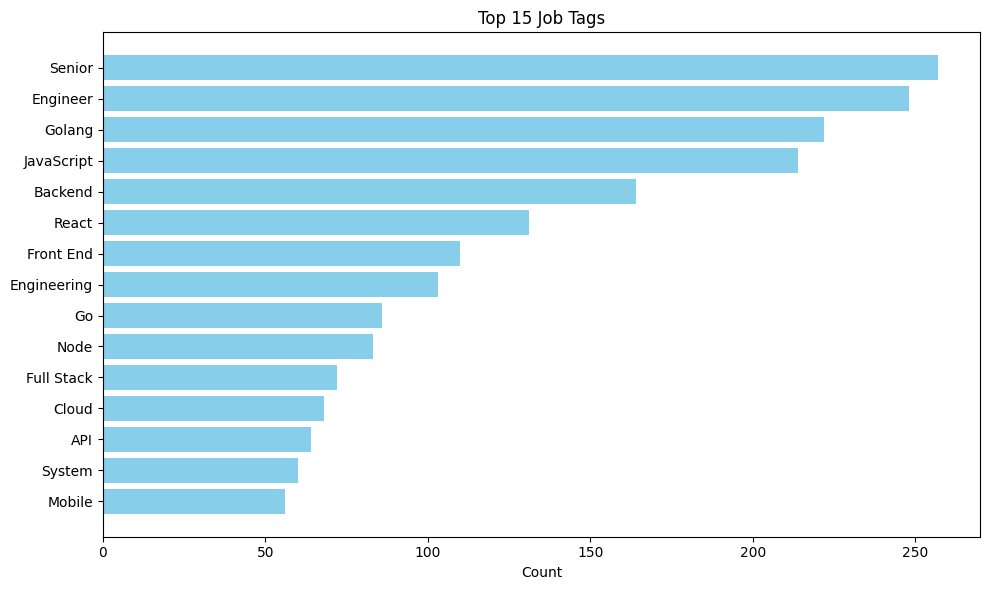

In [20]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten all tags into a single list
all_tags = [tag for tags in job_list_pd['tags'] for tag in tags]
tag_counts = Counter(all_tags).most_common(15)

# Convert to DataFrame for plotting
tags_df = pd.DataFrame(tag_counts, columns=["Tag", "Count"])

# Plot
plt.figure(figsize=(10, 6))
plt.barh(tags_df["Tag"], tags_df["Count"], color="skyblue")
plt.xlabel("Count")
plt.title("Top 15 Job Tags")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


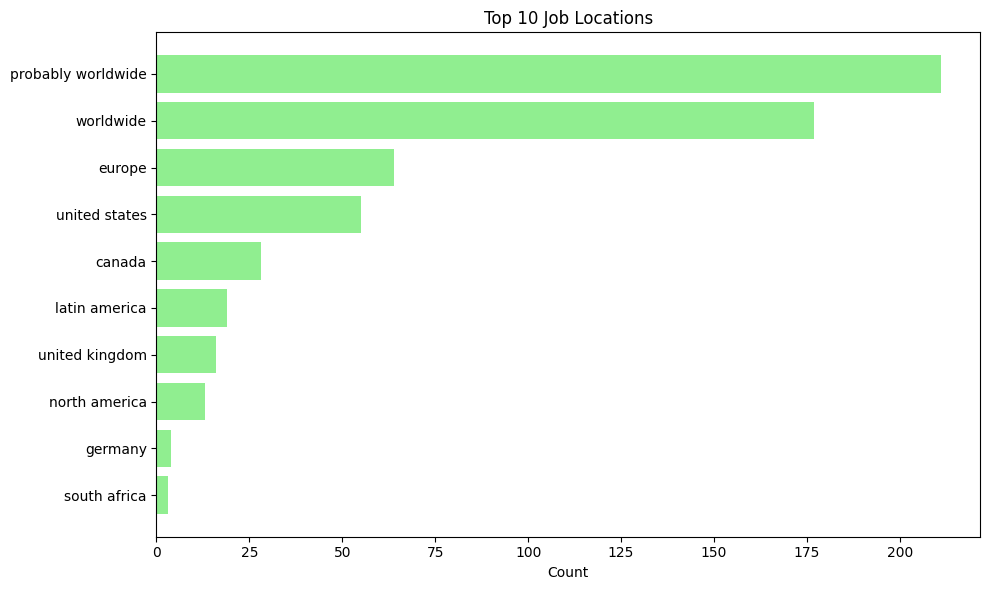

In [21]:
from collections import Counter

# Flatten locations if they are comma-separated
all_locs = [loc.strip() for row in job_list_pd["locations"] for loc in row.split(",")]
loc_counts = Counter(all_locs).most_common(10)

# Plot
loc_df = pd.DataFrame(loc_counts, columns=["Location", "Count"])
plt.figure(figsize=(10, 6))
plt.barh(loc_df["Location"], loc_df["Count"], color="lightgreen")
plt.xlabel("Count")
plt.title("Top 10 Job Locations")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


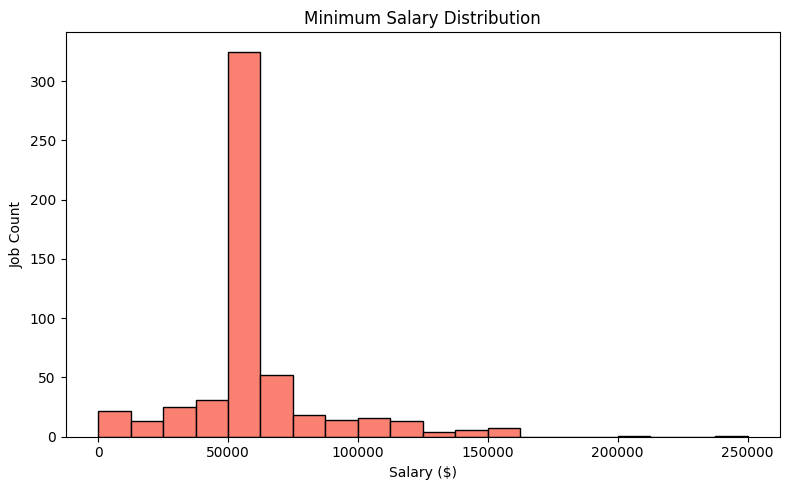

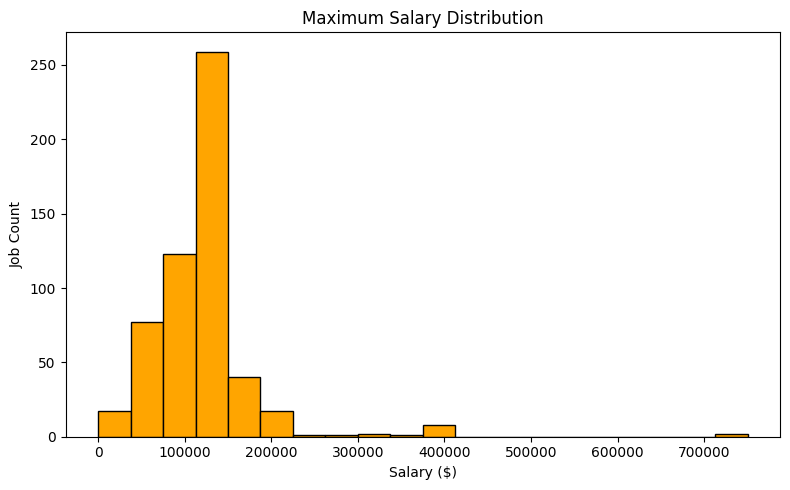

In [22]:
# Only include rows with valid salaries
salaries = job_list_pd.dropna(subset=["min salary", "max salary"])

# Plot min salary
plt.figure(figsize=(8, 5))
plt.hist(salaries["min salary"], bins=20, color="salmon", edgecolor="black")
plt.title("Minimum Salary Distribution")
plt.xlabel("Salary ($)")
plt.ylabel("Job Count")
plt.tight_layout()
plt.show()

# Plot max salary
plt.figure(figsize=(8, 5))
plt.hist(salaries["max salary"], bins=20, color="orange", edgecolor="black")
plt.title("Maximum Salary Distribution")
plt.xlabel("Salary ($)")
plt.ylabel("Job Count")
plt.tight_layout()
plt.show()


In [23]:
def time_to_days(time_str):
    if not isinstance(time_str, str):
        return float('inf')  # push invalid ones to the end
    time_str = time_str.strip().lower()
    if "day" in time_str or "d" in time_str:
        return int(re.search(r'\d+', time_str).group())
    elif "w" in time_str:
        return int(re.search(r'\d+', time_str).group()) * 7
    elif "mo" in time_str:
        return int(re.search(r'\d+', time_str).group()) * 30
    elif "yr" in time_str:
        return int(re.search(r'\d+', time_str).group()) * 365
    return float('inf')


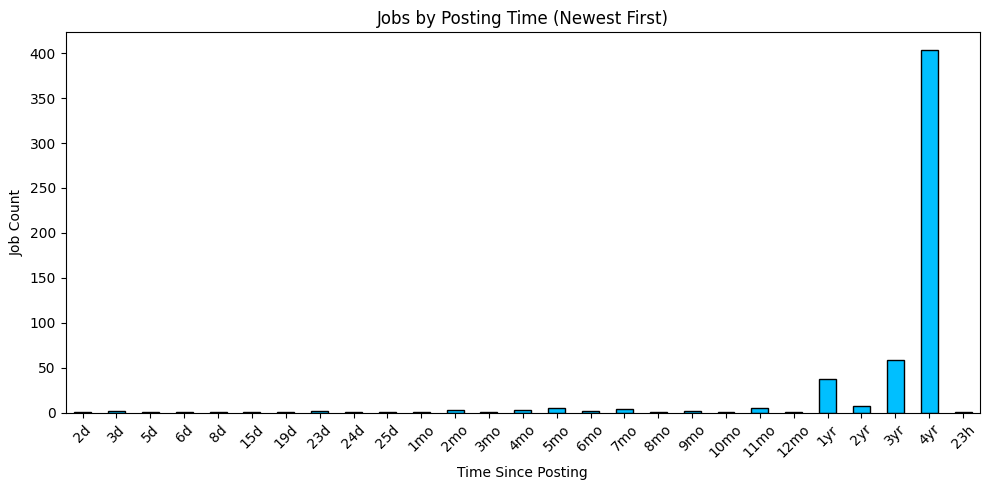

In [24]:
# Drop missing
posted = job_list_pd.dropna(subset=["time"]).copy()

# Convert time strings to days
posted["days_ago"] = posted["time"].apply(time_to_days)

# Count and sort by recency (lower = newer)
time_counts = posted["time"].value_counts()
time_counts = time_counts.loc[posted.sort_values("days_ago")["time"].unique()]

# Plot
plt.figure(figsize=(10, 5))
time_counts.plot(kind="bar", color="deepskyblue", edgecolor="black")
plt.title("Jobs by Posting Time (Newest First)")
plt.ylabel("Job Count")
plt.xlabel("Time Since Posting")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
job_list_pd.to_csv("remote_jobs.csv", index=False, encoding='utf-8-sig')

In [28]:
import sys
print(sys.executable)


d:\Projects\Small Scraper\venv\Scripts\python.exe
